In [1]:
!pip install tqdm

from tqdm import tqdm
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint
from PIL import Image
import tensorflow as tf

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [0]:
tf.set_random_seed(10)
np.random.seed(10)

In [3]:

df = pd.read_csv('https://github.com/harveenchadha/dump-nn-tf/raw/master/Section2/NN_Predict_Fraud/train.csv')
df.dropna(inplace=True)
iris = tf.contrib.learn.datasets.load_iris()

scl = StandardScaler()

Instructions for updating:
Use scikits.learn.datasets.
Instructions for updating:
Use tf.data instead.


In [0]:
def WeightsVariable(shape, name = 'weights'):
    return tf.Variable(tf.truncated_normal(shape, mean = 0.0, stddev=0.001, name=name))

def BiasVariable(shape, name = 'biases'):
    return tf.Variable(tf.constant(1.0, shape=[shape], name='biases'))

In [0]:
def network(images, channels = 1, input_shape = 4, output_shape = 3):
    num_c = [input_shape, 256, 128, 64, 32, 16, 8, 4, output_shape]
    num_i = 1
    with tf.name_scope('fc1'):
        weights = WeightsVariable([input_shape, num_c[num_i]])
        biases = BiasVariable(num_c[num_i])
        fc1 = tf.nn.relu(tf.matmul(images, weights) + biases)
    num_i += 1
    with tf.name_scope('fc2'):
        weights = WeightsVariable([num_c[num_i - 1], num_c[num_i]])
        biases = BiasVariable(num_c[num_i])
        fc1 = tf.nn.relu(tf.matmul(fc1, weights) + biases)
    num_i += 1    
    with tf.name_scope('fc3'):
        weights = WeightsVariable([num_c[num_i - 1], num_c[num_i]])
        biases = BiasVariable(num_c[num_i])
        fc1 = tf.nn.relu(tf.matmul(fc1, weights) + biases)
    num_i += 1    
    with tf.name_scope('fc5'):
        weights = WeightsVariable([num_c[num_i - 1], num_c[num_i]])
        biases = BiasVariable(num_c[num_i])
        fc1 = tf.nn.relu(tf.matmul(fc1, weights) + biases)
    num_i += 1    
    with tf.name_scope('fc6'):
        weights = WeightsVariable([num_c[num_i - 1], num_c[num_i]])
        biases = BiasVariable(num_c[num_i])
        fc1 = tf.nn.relu(tf.matmul(fc1, weights) + biases)   
    num_i += 1
    with tf.name_scope('fc4'):
        weights = WeightsVariable([num_c[num_i - 1], output_shape])
        biases = BiasVariable(output_shape)
        fc2 = tf.matmul(fc1, weights) + biases
    return fc2

In [0]:
def loss_metrics(logits, labels, output_shape=1):
    logits = logits
    if output_shape == 1:
      cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels = labels, 
                                                                   logits = logits, 
                                                                   name = 'softmax')
      
    else:
      cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = labels, 
                                                                   logits = logits, 
                                                                   name = 'softmax')
    return tf.reduce_mean(cross_entropy, name = 'softmax_mean')

In [0]:
#returns the optimizer by taking the loss
def training(loss):
    global_step = tf.Variable(0, name = 'global_step', trainable = False)
    
    learning_rate = tf.train.exponential_decay(STARTER_LR, 
                                               global_step = global_step, 
                                               decay_steps = 200, 
                                               decay_rate = 0.6, 
                                               staircase = True)
    optimizer = tf.train.AdamOptimizer(learning_rate = STARTER_LR)
    train_op = optimizer.minimize(loss)
    return train_op
    

In [0]:
def evaluation(logits, labels, output_shape = 1):
    correct = tf.nn.in_top_k(logits, labels, k = 1)
    return tf.reduce_sum(tf.cast(correct, tf.int32))#, accuracy1, accuracy2
  
def acc(logits, labels, output_shape = 1):
  
    if(output_shape == 1):
        correct_prediction = tf.equal(tf.cast(tf.greater_equal(logits,0.5), tf.float32), tf.cast(labels, tf.float32))
        
    else:
        correct_prediction = tf.equal(tf.argmax(logits, 1),  tf.cast(labels, tf.int64), name='correct_pred')
    
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')
    return accuracy

In [0]:
def placeholder_inputs(batch_size, input_shape=None, output_shape=1):
    image_placeholder = tf.placeholder(tf.float32, shape = (None, input_shape))
    if output_shape == 1:
      label_placeholder = tf.placeholder(tf.float32, shape = (None))
    else:
      label_placeholder = tf.placeholder(tf.int32, shape = (None))
    return image_placeholder, label_placeholder

In [0]:

loss_plot = []
acc_plot = []
train_plot = []
def run_training(x, y, input_shape=None, output_shape=1):
  
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)
    with tf.Graph().as_default():

        images_pl, labels_pl = placeholder_inputs(BATCH_SIZE, input_shape=input_shape, output_shape = output_shape)
        logits = network(images_pl, input_shape=input_shape, output_shape=output_shape)
        
        print("Logits Calculated Successfully")
        loss = loss_metrics(logits = logits, labels = labels_pl, output_shape = output_shape)
        train_op = training(loss)
#         eval_correct = evaluation(logits, labels_pl)
        acc_val = acc(logits, labels_pl, output_shape = output_shape)
        summary = tf.summary.merge_all()
        
        init = tf.global_variables_initializer()
        
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9) #OPTIONAL
        sess = tf.Session(config=tf.ConfigProto(gpu_options = gpu_options))
        
        saver = tf.train.Saver()
        sess.run(init)
        for steps in range(MAX_STEPS):
            loss_avg = []
            for i in tqdm(np.arange(0, len(x_train), BATCH_SIZE)):
                images_feed = x_train[i*BATCH_SIZE:i*(BATCH_SIZE+1)]
                labels_feed = y_train[i*BATCH_SIZE:i*(BATCH_SIZE+1)]

                feed_dict = { images_pl: images_feed, labels_pl: labels_feed }

                _ = sess.run([train_op], feed_dict = feed_dict)
                

            images_feed = x_test
            labels_feed = y_test

            feed_dict = {
                images_pl: images_feed,
                labels_pl: labels_feed
                        }
            loss_  = sess.run([loss], feed_dict = feed_dict)
            accuracy_val  = sess.run([acc_val], feed_dict = feed_dict)
            images_feed = x_train
            labels_feed = y_train

            feed_dict = {
                images_pl: images_feed,
                labels_pl: labels_feed
                        }
            train_loss  = sess.run([loss], feed_dict = feed_dict)
            
            loss_plot.append(loss_)
            train_plot.append(train_loss)
            acc_plot.append(accuracy_val)
            print('Loss %d: Training loss = %.5f  Validation loss = %.5f\t Validation Acc = %.5f' % (steps+1, train_loss[0], loss_[0], accuracy_val[0]))     
          
        return sess, images_pl, labels_pl, acc_val, logits

In [60]:

# x = iris[0]
# y = iris[1]

x = df.iloc[:, :30]
y = df.iloc[:, -1:]


x = scl.fit_transform(x)

STARTER_LR = 7e-5
BATCH_SIZE = 2
MAX_STEPS = 100

loss_plot = []
acc_plot = []
train_plot = []
sess, images_pl, labels_pl, eval_correct, logits = run_training(np.asarray(x, dtype = np.float32), np.asarray(y, dtype = np.float32), input_shape=x.shape[1], output_shape=y.shape[1])

Logits Calculated Successfully


 20%|█▉        | 62/315 [00:00<00:00, 606.40it/s]

Loss 1: Training loss = 0.74140  Validation loss = 0.79696	 Validation Acc = 0.47037


 20%|██        | 64/315 [00:00<00:00, 628.78it/s]

Loss 2: Training loss = 0.61188  Validation loss = 0.65423	 Validation Acc = 0.47037


 19%|█▊        | 59/315 [00:00<00:00, 579.72it/s]

Loss 3: Training loss = 0.58595  Validation loss = 0.63497	 Validation Acc = 0.47037


 20%|█▉        | 62/315 [00:00<00:00, 616.79it/s]

Loss 4: Training loss = 0.55939  Validation loss = 0.61365	 Validation Acc = 0.58889


 20%|█▉        | 62/315 [00:00<00:00, 615.67it/s]

Loss 5: Training loss = 0.53516  Validation loss = 0.59380	 Validation Acc = 0.62222


 20%|██        | 63/315 [00:00<00:00, 622.50it/s]

Loss 6: Training loss = 0.51323  Validation loss = 0.57602	 Validation Acc = 0.65185


 18%|█▊        | 58/315 [00:00<00:00, 570.92it/s]

Loss 7: Training loss = 0.49384  Validation loss = 0.56019	 Validation Acc = 0.67407


 20%|██        | 63/315 [00:00<00:00, 621.99it/s]

Loss 8: Training loss = 0.47749  Validation loss = 0.54679	 Validation Acc = 0.69259


 20%|██        | 63/315 [00:00<00:00, 624.73it/s]

Loss 9: Training loss = 0.46244  Validation loss = 0.53423	 Validation Acc = 0.70000


 20%|█▉        | 62/315 [00:00<00:00, 611.08it/s]

Loss 10: Training loss = 0.44828  Validation loss = 0.52143	 Validation Acc = 0.71481


 20%|██        | 63/315 [00:00<00:00, 616.79it/s]

Loss 11: Training loss = 0.43617  Validation loss = 0.51080	 Validation Acc = 0.72593


 20%|██        | 64/315 [00:00<00:00, 633.05it/s]

Loss 12: Training loss = 0.42470  Validation loss = 0.50002	 Validation Acc = 0.74444


 20%|██        | 63/315 [00:00<00:00, 628.59it/s]

Loss 13: Training loss = 0.41287  Validation loss = 0.48811	 Validation Acc = 0.75556


 20%|█▉        | 62/315 [00:00<00:00, 614.02it/s]

Loss 14: Training loss = 0.40292  Validation loss = 0.47925	 Validation Acc = 0.75926


 20%|██        | 63/315 [00:00<00:00, 616.82it/s]

Loss 15: Training loss = 0.39200  Validation loss = 0.46804	 Validation Acc = 0.76667


 20%|██        | 63/315 [00:00<00:00, 622.78it/s]

Loss 16: Training loss = 0.38228  Validation loss = 0.45918	 Validation Acc = 0.77037


 20%|██        | 63/315 [00:00<00:00, 614.78it/s]

Loss 17: Training loss = 0.37331  Validation loss = 0.45228	 Validation Acc = 0.77778


 20%|██        | 63/315 [00:00<00:00, 622.53it/s]

Loss 18: Training loss = 0.36281  Validation loss = 0.43996	 Validation Acc = 0.78889


 20%|██        | 63/315 [00:00<00:00, 621.11it/s]

Loss 19: Training loss = 0.35438  Validation loss = 0.43422	 Validation Acc = 0.80000


 20%|██        | 63/315 [00:00<00:00, 624.95it/s]

Loss 20: Training loss = 0.34310  Validation loss = 0.41801	 Validation Acc = 0.81481


 20%|██        | 64/315 [00:00<00:00, 623.67it/s]

Loss 21: Training loss = 0.33734  Validation loss = 0.41912	 Validation Acc = 0.81852


 20%|██        | 64/315 [00:00<00:00, 635.78it/s]

Loss 22: Training loss = 0.32600  Validation loss = 0.40136	 Validation Acc = 0.81852


 20%|██        | 64/315 [00:00<00:00, 635.09it/s]

Loss 23: Training loss = 0.32647  Validation loss = 0.41382	 Validation Acc = 0.81852


 21%|██        | 65/315 [00:00<00:00, 633.69it/s]

Loss 24: Training loss = 0.31104  Validation loss = 0.39034	 Validation Acc = 0.82593


 21%|██        | 66/315 [00:00<00:00, 648.90it/s]

Loss 25: Training loss = 0.31144  Validation loss = 0.40126	 Validation Acc = 0.82593


 20%|██        | 64/315 [00:00<00:00, 627.63it/s]

Loss 26: Training loss = 0.29505  Validation loss = 0.37699	 Validation Acc = 0.82963


 20%|██        | 64/315 [00:00<00:00, 630.21it/s]

Loss 27: Training loss = 0.29710  Validation loss = 0.38753	 Validation Acc = 0.83333


 21%|██        | 65/315 [00:00<00:00, 637.92it/s]

Loss 28: Training loss = 0.28847  Validation loss = 0.37929	 Validation Acc = 0.83333


 21%|██        | 65/315 [00:00<00:00, 647.77it/s]

Loss 29: Training loss = 0.27913  Validation loss = 0.36841	 Validation Acc = 0.84074


 21%|██        | 65/315 [00:00<00:00, 645.46it/s]

Loss 30: Training loss = 0.28919  Validation loss = 0.39162	 Validation Acc = 0.84074


 20%|██        | 64/315 [00:00<00:00, 635.47it/s]

Loss 31: Training loss = 0.26505  Validation loss = 0.35548	 Validation Acc = 0.85185


 20%|██        | 64/315 [00:00<00:00, 633.57it/s]

Loss 32: Training loss = 0.25100  Validation loss = 0.33842	 Validation Acc = 0.86667


 20%|██        | 63/315 [00:00<00:00, 617.07it/s]

Loss 33: Training loss = 0.24679  Validation loss = 0.33591	 Validation Acc = 0.86667


 20%|██        | 64/315 [00:00<00:00, 628.50it/s]

Loss 34: Training loss = 0.24251  Validation loss = 0.33343	 Validation Acc = 0.86667


 20%|██        | 63/315 [00:00<00:00, 624.86it/s]

Loss 35: Training loss = 0.22355  Validation loss = 0.30331	 Validation Acc = 0.87407


 21%|██        | 65/315 [00:00<00:00, 635.61it/s]

Loss 36: Training loss = 0.21712  Validation loss = 0.29712	 Validation Acc = 0.88148


 21%|██        | 65/315 [00:00<00:00, 643.87it/s]

Loss 37: Training loss = 0.20476  Validation loss = 0.27473	 Validation Acc = 0.88148


 20%|██        | 64/315 [00:00<00:00, 629.46it/s]

Loss 38: Training loss = 0.19829  Validation loss = 0.26454	 Validation Acc = 0.88519


 20%|██        | 64/315 [00:00<00:00, 632.06it/s]

Loss 39: Training loss = 0.19283  Validation loss = 0.25827	 Validation Acc = 0.88519


 20%|██        | 64/315 [00:00<00:00, 636.53it/s]

Loss 40: Training loss = 0.18764  Validation loss = 0.25198	 Validation Acc = 0.88519


 20%|██        | 64/315 [00:00<00:00, 634.74it/s]

Loss 41: Training loss = 0.18281  Validation loss = 0.24685	 Validation Acc = 0.89259


 21%|██        | 65/315 [00:00<00:00, 635.94it/s]

Loss 42: Training loss = 0.17838  Validation loss = 0.24060	 Validation Acc = 0.89630


 20%|██        | 63/315 [00:00<00:00, 626.15it/s]

Loss 43: Training loss = 0.17432  Validation loss = 0.23536	 Validation Acc = 0.89630


 21%|██        | 65/315 [00:00<00:00, 634.53it/s]

Loss 44: Training loss = 0.17060  Validation loss = 0.23068	 Validation Acc = 0.89630


 20%|██        | 63/315 [00:00<00:00, 625.49it/s]

Loss 45: Training loss = 0.16709  Validation loss = 0.22681	 Validation Acc = 0.90000


 20%|██        | 63/315 [00:00<00:00, 629.91it/s]

Loss 46: Training loss = 0.16389  Validation loss = 0.22311	 Validation Acc = 0.90370


 20%|██        | 63/315 [00:00<00:00, 624.15it/s]

Loss 47: Training loss = 0.16090  Validation loss = 0.21987	 Validation Acc = 0.90370


 19%|█▉        | 61/315 [00:00<00:00, 602.95it/s]

Loss 48: Training loss = 0.15810  Validation loss = 0.21706	 Validation Acc = 0.91481


 20%|██        | 63/315 [00:00<00:00, 623.09it/s]

Loss 49: Training loss = 0.15575  Validation loss = 0.21404	 Validation Acc = 0.91852


 20%|██        | 63/315 [00:00<00:00, 614.19it/s]

Loss 50: Training loss = 0.15347  Validation loss = 0.21159	 Validation Acc = 0.92222


 20%|██        | 63/315 [00:00<00:00, 623.11it/s]

Loss 51: Training loss = 0.15135  Validation loss = 0.20953	 Validation Acc = 0.92222


 20%|█▉        | 62/315 [00:00<00:00, 614.00it/s]

Loss 52: Training loss = 0.14952  Validation loss = 0.20740	 Validation Acc = 0.92222


 20%|█▉        | 62/315 [00:00<00:00, 618.35it/s]

Loss 53: Training loss = 0.14785  Validation loss = 0.20561	 Validation Acc = 0.92222


 20%|█▉        | 62/315 [00:00<00:00, 616.24it/s]

Loss 54: Training loss = 0.14540  Validation loss = 0.20649	 Validation Acc = 0.92222


 20%|██        | 63/315 [00:00<00:00, 619.44it/s]

Loss 55: Training loss = 0.14374  Validation loss = 0.20982	 Validation Acc = 0.91852


 20%|██        | 63/315 [00:00<00:00, 616.82it/s]

Loss 56: Training loss = 0.14427  Validation loss = 0.20047	 Validation Acc = 0.92593


 20%|█▉        | 62/315 [00:00<00:00, 606.12it/s]

Loss 57: Training loss = 0.14456  Validation loss = 0.19835	 Validation Acc = 0.92593


 20%|█▉        | 62/315 [00:00<00:00, 609.33it/s]

Loss 58: Training loss = 0.14294  Validation loss = 0.19773	 Validation Acc = 0.92593


 20%|█▉        | 62/315 [00:00<00:00, 604.73it/s]

Loss 59: Training loss = 0.14128  Validation loss = 0.19762	 Validation Acc = 0.92593


 19%|█▉        | 61/315 [00:00<00:00, 597.19it/s]

Loss 60: Training loss = 0.13954  Validation loss = 0.19808	 Validation Acc = 0.92593


 20%|██        | 63/315 [00:00<00:00, 623.60it/s]

Loss 61: Training loss = 0.14084  Validation loss = 0.21885	 Validation Acc = 0.91852


 20%|██        | 63/315 [00:00<00:00, 615.02it/s]

Loss 62: Training loss = 0.13745  Validation loss = 0.19816	 Validation Acc = 0.92593


 19%|█▉        | 61/315 [00:00<00:00, 601.56it/s]

Loss 63: Training loss = 0.13755  Validation loss = 0.19665	 Validation Acc = 0.92593


 20%|██        | 63/315 [00:00<00:00, 615.65it/s]

Loss 64: Training loss = 0.13585  Validation loss = 0.20386	 Validation Acc = 0.92593


 20%|██        | 64/315 [00:00<00:00, 628.09it/s]

Loss 65: Training loss = 0.13610  Validation loss = 0.19664	 Validation Acc = 0.92963


 20%|██        | 63/315 [00:00<00:00, 622.98it/s]

Loss 66: Training loss = 0.13510  Validation loss = 0.19753	 Validation Acc = 0.92963


 20%|██        | 63/315 [00:00<00:00, 619.38it/s]

Loss 67: Training loss = 0.13428  Validation loss = 0.19953	 Validation Acc = 0.92963


 20%|██        | 64/315 [00:00<00:00, 625.51it/s]

Loss 68: Training loss = 0.13504  Validation loss = 0.19529	 Validation Acc = 0.92963


 20%|██        | 64/315 [00:00<00:00, 636.26it/s]

Loss 69: Training loss = 0.13438  Validation loss = 0.20733	 Validation Acc = 0.92963


 20%|██        | 63/315 [00:00<00:00, 613.80it/s]

Loss 70: Training loss = 0.13455  Validation loss = 0.19456	 Validation Acc = 0.92963


 20%|██        | 63/315 [00:00<00:00, 627.93it/s]

Loss 71: Training loss = 0.13344  Validation loss = 0.19679	 Validation Acc = 0.92963


 20%|█▉        | 62/315 [00:00<00:00, 619.56it/s]

Loss 72: Training loss = 0.13460  Validation loss = 0.19401	 Validation Acc = 0.92963


 20%|██        | 63/315 [00:00<00:00, 622.91it/s]

Loss 73: Training loss = 0.13585  Validation loss = 0.19311	 Validation Acc = 0.93333


 20%|█▉        | 62/315 [00:00<00:00, 599.62it/s]

Loss 74: Training loss = 0.13442  Validation loss = 0.19385	 Validation Acc = 0.93333


 19%|█▉        | 61/315 [00:00<00:00, 602.45it/s]

Loss 75: Training loss = 0.13525  Validation loss = 0.19335	 Validation Acc = 0.93333


 20%|█▉        | 62/315 [00:00<00:00, 616.02it/s]

Loss 76: Training loss = 0.13394  Validation loss = 0.19410	 Validation Acc = 0.93333


 20%|██        | 63/315 [00:00<00:00, 628.31it/s]

Loss 77: Training loss = 0.14430  Validation loss = 0.24071	 Validation Acc = 0.91852


 20%|██        | 63/315 [00:00<00:00, 615.39it/s]

Loss 78: Training loss = 0.13530  Validation loss = 0.19234	 Validation Acc = 0.92963


 19%|█▉        | 61/315 [00:00<00:00, 609.87it/s]

Loss 79: Training loss = 0.13401  Validation loss = 0.19274	 Validation Acc = 0.92963


 19%|█▉        | 61/315 [00:00<00:00, 606.61it/s]

Loss 80: Training loss = 0.13248  Validation loss = 0.19350	 Validation Acc = 0.92963


 19%|█▉        | 60/315 [00:00<00:00, 596.90it/s]

Loss 81: Training loss = 0.13198  Validation loss = 0.19367	 Validation Acc = 0.92963


 20%|█▉        | 62/315 [00:00<00:00, 612.17it/s]

Loss 82: Training loss = 0.13234  Validation loss = 0.19345	 Validation Acc = 0.92963


 19%|█▉        | 60/315 [00:00<00:00, 589.25it/s]

Loss 83: Training loss = 0.13138  Validation loss = 0.19412	 Validation Acc = 0.92963


 19%|█▉        | 61/315 [00:00<00:00, 596.16it/s]

Loss 84: Training loss = 0.13210  Validation loss = 0.19355	 Validation Acc = 0.92963


 19%|█▉        | 60/315 [00:00<00:00, 590.11it/s]

Loss 85: Training loss = 0.12956  Validation loss = 0.19714	 Validation Acc = 0.92963


 19%|█▉        | 61/315 [00:00<00:00, 598.36it/s]

Loss 86: Training loss = 0.13146  Validation loss = 0.19392	 Validation Acc = 0.92963


 20%|█▉        | 62/315 [00:00<00:00, 601.65it/s]

Loss 87: Training loss = 0.13117  Validation loss = 0.19391	 Validation Acc = 0.92963


 20%|█▉        | 62/315 [00:00<00:00, 608.72it/s]

Loss 88: Training loss = 0.13112  Validation loss = 0.19450	 Validation Acc = 0.92963


 20%|██        | 63/315 [00:00<00:00, 622.98it/s]

Loss 89: Training loss = 0.13359  Validation loss = 0.22080	 Validation Acc = 0.92593


 19%|█▉        | 61/315 [00:00<00:00, 602.90it/s]

Loss 90: Training loss = 0.13026  Validation loss = 0.19482	 Validation Acc = 0.92963


 19%|█▉        | 60/315 [00:00<00:00, 594.93it/s]

Loss 91: Training loss = 0.12897  Validation loss = 0.19840	 Validation Acc = 0.92963


 19%|█▉        | 60/315 [00:00<00:00, 591.85it/s]

Loss 92: Training loss = 0.13025  Validation loss = 0.19510	 Validation Acc = 0.92963


 19%|█▉        | 61/315 [00:00<00:00, 598.79it/s]

Loss 93: Training loss = 0.13159  Validation loss = 0.19502	 Validation Acc = 0.92963


 18%|█▊        | 57/315 [00:00<00:00, 565.62it/s]

Loss 94: Training loss = 0.13156  Validation loss = 0.19468	 Validation Acc = 0.92963


 19%|█▊        | 59/315 [00:00<00:00, 585.97it/s]

Loss 95: Training loss = 0.13183  Validation loss = 0.19499	 Validation Acc = 0.92963


 19%|█▉        | 60/315 [00:00<00:00, 590.65it/s]

Loss 96: Training loss = 0.13126  Validation loss = 0.19514	 Validation Acc = 0.93333


 19%|█▉        | 61/315 [00:00<00:00, 609.20it/s]

Loss 97: Training loss = 0.13071  Validation loss = 0.19531	 Validation Acc = 0.92963


 19%|█▉        | 61/315 [00:00<00:00, 605.58it/s]

Loss 98: Training loss = 0.13035  Validation loss = 0.19538	 Validation Acc = 0.93333


 20%|█▉        | 62/315 [00:00<00:00, 615.29it/s]

Loss 99: Training loss = 0.13031  Validation loss = 0.19542	 Validation Acc = 0.93333


100%|██████████| 315/315 [00:00<00:00, 635.25it/s]


Loss 100: Training loss = 0.13061  Validation loss = 0.19563	 Validation Acc = 0.93333


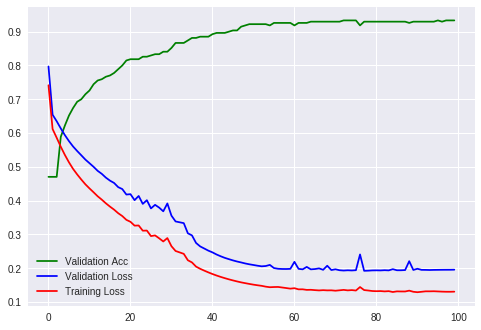

In [62]:
sns.set_style("darkgrid")
plt.plot(acc_plot,'g-',label="Validation Acc")
plt.plot(loss_plot, 'b-', label="Validation Loss")
plt.plot(train_plot, "r-", label='Training Loss')
plt.legend(loc='best')

In [13]:
images_feed, labels_feed = MNIST_DATASETS.validation.images, MNIST_DATASETS.validation.labels

feed_dict = {
    images_pl: np.reshape(images_feed, (-1, 28, 28, 1))
            }
with sess.as_default():
  accuracy  = sess.run([logits], feed_dict = feed_dict)
  
  preds = np.argmax(accuracy[0], 1)
  print(preds)

NameError: ignored

In [0]:
from sklearn.metrics import classification_report
print(classification_report(labels_feed, preds))

             precision    recall  f1-score   support

          0       0.99      0.99      0.99       479
          1       0.97      0.98      0.97       563
          2       0.98      0.93      0.96       488
          3       0.98      0.96      0.97       493
          4       0.98      0.98      0.98       535
          5       0.96      0.98      0.97       434
          6       0.98      0.98      0.98       501
          7       0.96      0.97      0.97       550
          8       0.96      0.97      0.97       462
          9       0.96      0.96      0.96       495

avg / total       0.97      0.97      0.97      5000



In [0]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(labels_feed, preds))

[[473   0   0   0   0   2   2   0   0   2]
 [  0 553   2   2   1   0   1   2   2   0]
 [  1  10 454   5   1   1   0   7   8   1]
 [  0   1   2 475   0   7   0   5   2   1]
 [  0   1   0   0 526   0   4   1   0   3]
 [  0   1   1   0   1 427   0   0   3   1]
 [  3   2   0   0   1   1 493   0   1   0]
 [  0   2   2   1   3   0   0 536   0   6]
 [  0   2   0   1   0   3   1   2 449   4]
 [  2   1   0   2   5   2   0   7   2 474]]


In [0]:
# graph = tf.GraphDef()
# graph.ParseFromString(tf_model.SerializeToString())

# with tf.Graph().as_default() as graph:
#         # The name var will prefix every op/nodes in your graph
#         # Since we load everything in a new graph, this is not needed
#     tf.import_graph_def(graph, name="prefix")
    
    